<a href="https://colab.research.google.com/github/Bhavani-Rajan/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import numpy as np
import pandas as pd


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')





In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)

test = wrangle(test)

In [0]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,years,years_MISSING
0,6000.0,Roman,1390.0,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,False,False,False,2011,3,14,12.0,False
1,0.0,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,NaN,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,False,False,False,False,False,2013,3,6,3.0,False
2,25.0,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,False,False,False,False,False,2013,2,25,4.0,False
3,0.0,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,False,False,False,False,False,2013,1,28,27.0,False
4,0.0,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,NaN,True,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,False,False,True,True,True,2011,7,13,NaN,True


In [0]:
train.isnull().sum()

amount_tsh                       0
funder                        3635
gps_height                   20438
installer                     3655
longitude                     1812
latitude                      1812
wpt_name                         0
num_private                      0
basin                            0
subvillage                     371
region                           0
region_code                      0
district_code                    0
lga                              0
ward                             0
population                   21381
public_meeting                3334
scheme_management             3877
scheme_name                  28166
permit                        3056
construction_year            20709
extraction_type                  0
extraction_type_group            0
extraction_type_class            0
management                       0
management_group                 0
payment                          0
water_quality                    0
quality_group       

In [0]:
train = train.dropna()

In [5]:
train.isnull().sum()

amount_tsh                   0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
scheme_management            0
scheme_name                  0
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
water_quality                0
quality_group                0
quantity                     0
source                       0
source_type                  0
source_c

In [0]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
features = train.columns.drop(target)
X = train[features]
y = train[target]



In [7]:
X.shape

(20399, 45)

In [8]:
y.value_counts()

functional                 12294
non functional              6530
functional needs repair     1575
Name: status_group, dtype: int64

In [0]:
train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,month_recorded,day_recorded,years
count,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000,20399.000000
mean,559.901368,1102.388499,36.112355,-5.959498,0.857444,12.304378,4.683514,215.664199,1995.892936,2012.189568,3.297122,15.532673,16.296632
std,3808.604148,569.722397,2.503392,2.668964,7.831604,18.091025,6.768759,405.262381,13.332159,0.984186,2.335080,8.977044,13.327090
min,0.000000,-63.000000,29.607122,-11.564509,0.000000,2.000000,1.000000,1.000000,1960.000000,2004.000000,1.000000,1.000000,-5.000000
25%,0.000000,695.000000,34.800889,-8.627351,0.000000,3.000000,2.000000,30.000000,1984.000000,2011.000000,2.000000,6.000000,5.000000
50%,10.000000,1227.000000,36.827895,-4.906265,0.000000,6.000000,3.000000,120.000000,2000.000000,2013.000000,3.000000,16.000000,12.000000
75%,250.000000,1529.000000,37.665787,-3.392542,0.000000,13.000000,5.000000,250.000000,2008.000000,2013.000000,3.000000,23.000000,28.000000
max,250000.000000,2628.000000,40.323402,-1.104943,280.000000,99.000000,62.000000,15300.000000,2013.000000,2013.000000,12.000000,31.000000,53.000000


In [0]:
train.describe(exclude='number')

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,years_MISSING
count,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399,20399
unique,643,689,13961,9,6423,16,72,861,2,10,1800,2,15,13,7,11,5,7,7,6,5,10,7,3,6,5,3,1,1,1,1,1,1
top,Government Of Tanzania,DWE,none,Pangani,Kati,Kilimanjaro,Njombe,Igosi,True,VWC,Chalinze wate,True,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,False,False,False,False
freq,4342,6237,1862,7258,235,4021,2187,301,18854,12278,402,16478,15696,15696,15696,13549,18238,5980,19387,19387,12891,9898,9898,12854,15602,19023,12294,20399,20399,20399,20399,20399,20399


In [0]:
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier


# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)
print(X_encoded.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)


(20399, 45)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

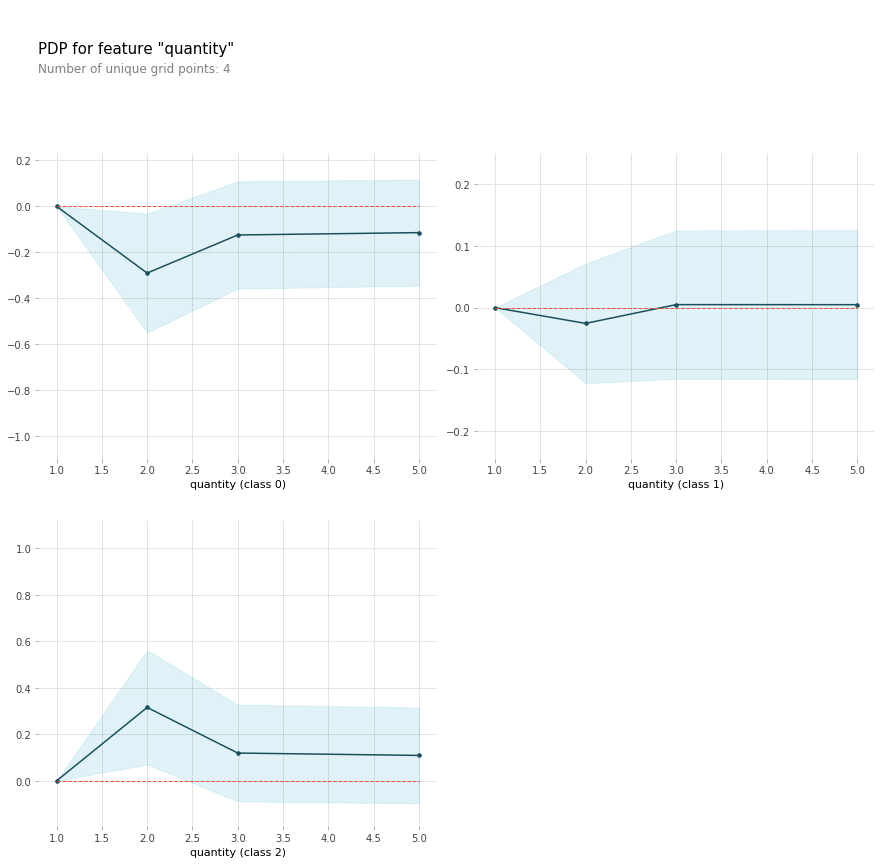

In [0]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'quantity'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

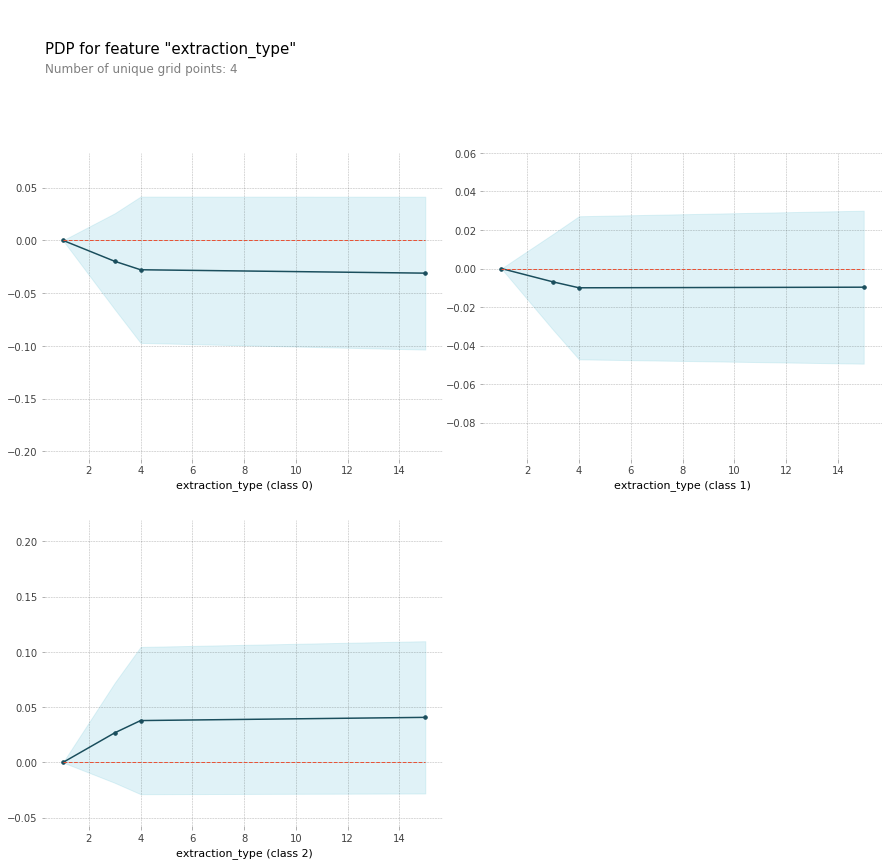

In [0]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'extraction_type'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [0]:
# Look at the encoder's mappings
encoder.mapping

[{'col': 'funder',
  'data_type': dtype('O'),
  'mapping': Roman                               1
  Lottery Club                        2
  Lawatefuka Water Supply             3
  Unicef                              4
  Danida                              5
  Twe                                 6
  Isf                                 7
  African Development Bank            8
  Government Of Tanzania              9
  Sobodo                             10
  Private Individual                 11
  Undp                               12
  Cefa                               13
  Ces(gmbh)                          14
  European Union                     15
  District Council                   16
  Muwsa                              17
  Dwe/norad                          18
  Ces (gmbh)                         19
  Olgilai Village Community          20
  Roman Catholic                     21
  Norad                              22
  Adra                               23
  Sema                 

In [0]:
# Let's automate it

feature = 'quantity'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

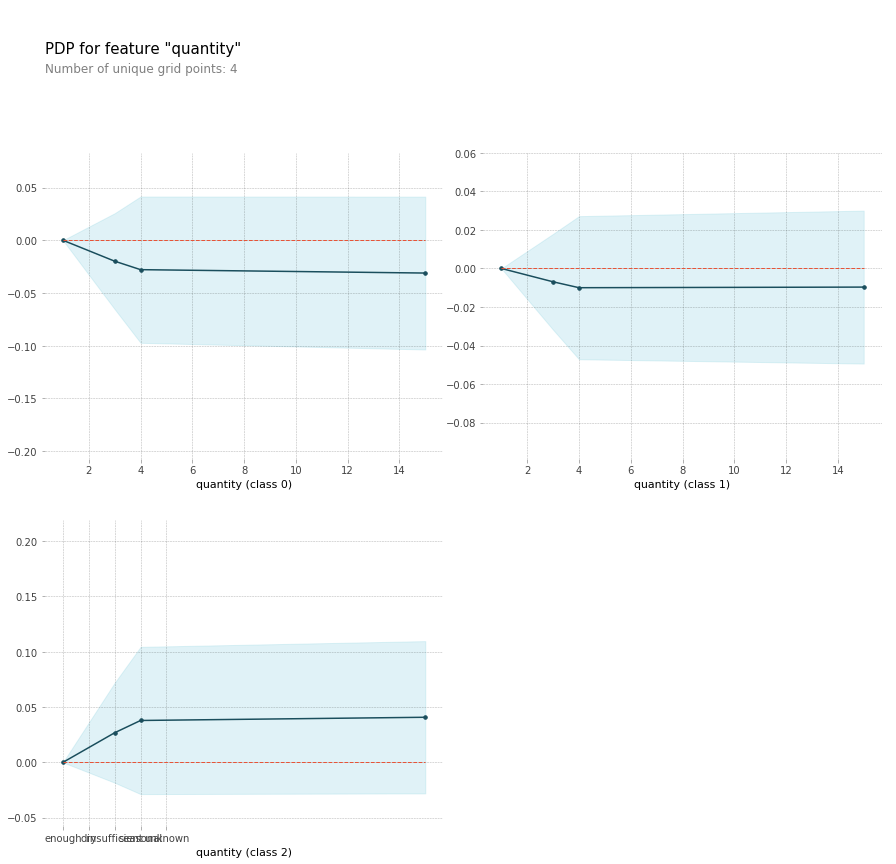

In [0]:
pdp.pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

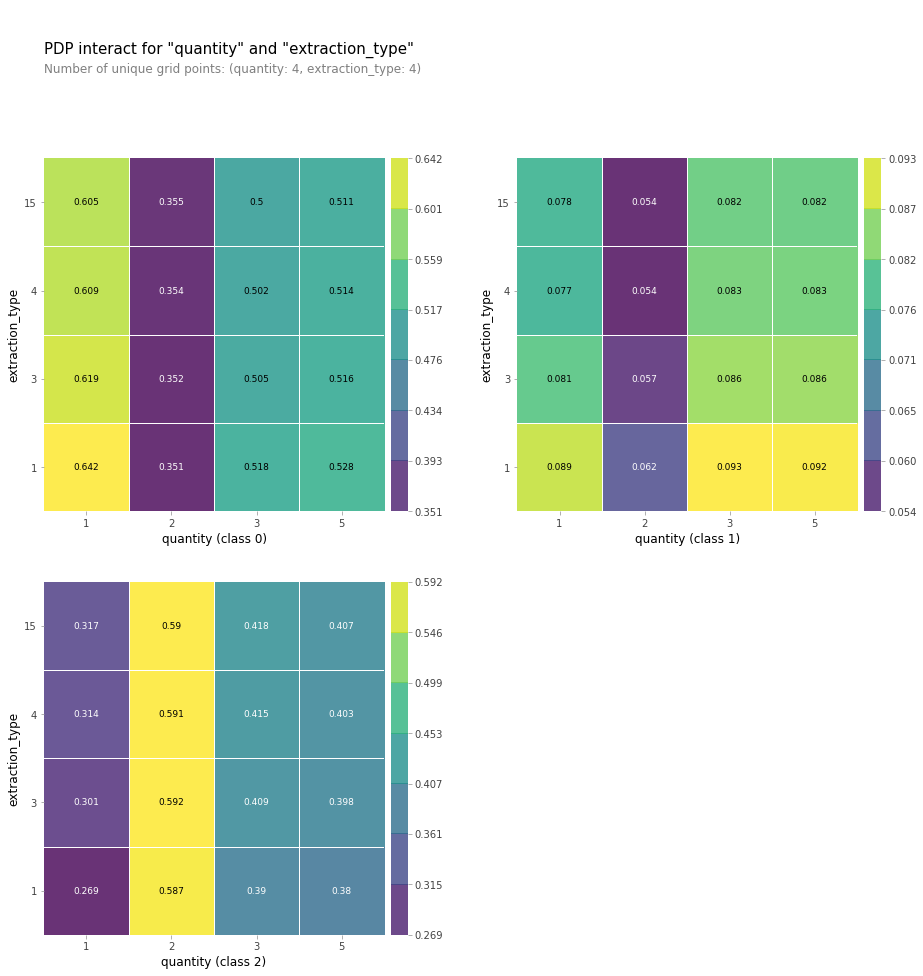

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['quantity', 'extraction_type']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [0]:
interaction

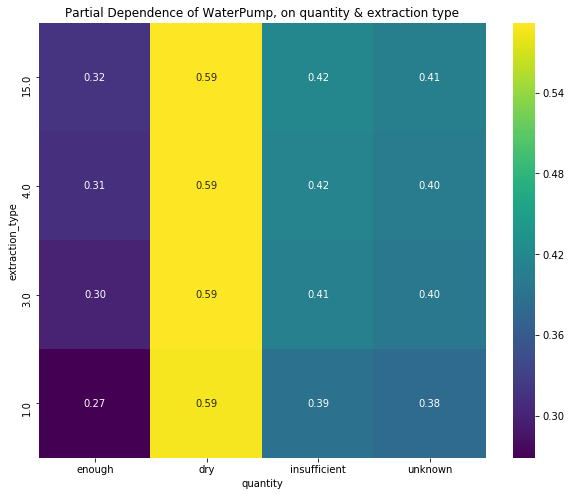

In [0]:
import seaborn as sns
pdp = interaction[2].pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of WaterPump, on quantity & extraction type');